In [203]:
import os
import sys
import json
import time
import wave
import random
import numpy as np
from typing import Dict, Tuple

import torch
import torchaudio
from torch.utils.data import DataLoader

from torchvision import transforms
from PIL import Image
import PIL


sys.path.append('../training')
from utils import data_utils, utils, audio_utils
from datasets.loader import Dataset

import matplotlib.pyplot as plt
import IPython.display as ipd

In [204]:
# main_dir = '/home/jaejun/nansy/
config_path = '../training/configs/f2v.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

# Face2Voice

In [191]:
class F2V_Dataset(torch.utils.data.Dataset):
    def __init__(self,
                args,
                meta_root = 'filelists',
                mode='train',
                img_datasets=['VGG_Face'],
                sample_rate = 16000, 
                ):
        self.args = args
        self.mode = mode
        self.img_datasets = img_datasets
        self.sample_rate = sample_rate
        self.max_sec = 4
        self.max_len = sample_rate * self.max_sec
        self.data_files = []
        for dset in img_datasets:
            meta_file_path = os.path.join(meta_root, '{}_{}.txt').format(dset, mode)
            files = data_utils.load_text(meta_file_path)
            self.data_files += files
        self.data_files_len = len(self.data_files)
        self.trans = transforms.Compose([transforms.Resize((args.features.image.size,args.features.image.size), interpolation=PIL.Image.BICUBIC),
                transforms.CenterCrop(args.features.image.size), transforms.ToTensor(),
                # transforms.Normalize(mean=[0.4850, 0.4560, 0.4060], std=[0.2290, 0.2240, 0.2250])])
                transforms.Normalize(mean=[0.4845, 0.4065, 0.3725], std=[0.2290, 0.2240, 0.2250])])
        
    def get_image(self, index):
        img = Image.open()
        
    def __getitem__(self, index):
        spkr = self.data_files[index % self.data_files_len]
        
        # image load
        img_names = os.listdir(os.path.join(self.args.data.img_datadir, spkr))
        random_img_name = random.choice(img_names)
        img_path = os.path.join(self.args.data.img_datadir, spkr, random_img_name)
        img = Image.open(img_path)
        img_tensor = self.trans(img)

        # audio load
        aud_names = os.listdir(os.path.join(self.args.data.aud_datadir, spkr))
        random_aud_name = random.choice(aud_names)
        aud_path = os.path.join(self.args.data.aud_datadir, spkr, random_aud_name)
        aud = audio_utils.load_wav(path=aud_path, sr=self.args.data.sample_rate,
                                   max_len=self.max_len, pos='random')
        aud_pad = np.pad(aud[:self.max_len], [0, self.max_len - len(aud)])
        return img_tensor, aud_pad

    def __len__(self):
        return len(self.data_files)*self.args.data.img_nums

class TMP_Dataset(torch.utils.data.Dataset):
    def __init__(self,
                args,
                meta_root = 'filelists',
                mode='train',
                img_datasets=['VGG_Face'],
                sample_rate = 16000, 
                ):
        self.args = args
        self.mode = mode
        self.img_datasets = img_datasets
        self.sample_rate = sample_rate
        self.max_sec = 4
        self.max_len = sample_rate * self.max_sec
        self.data_files = []
        for dset in img_datasets:
            meta_file_path = os.path.join(meta_root, '{}_{}.txt').format(dset, mode)
            files = data_utils.load_text(meta_file_path)
            self.data_files += files
        self.data_files_len = len(self.data_files)
        self.trans = transforms.Compose([transforms.Resize((args.features.image.size,args.features.image.size), interpolation=PIL.Image.BICUBIC),
                transforms.CenterCrop(args.features.image.size), transforms.ToTensor()])
        
    def get_image(self, index):
        img = Image.open()
        
    def __getitem__(self, index):
        img_path = self.data_files[index]
        img = Image.open(img_path)
        img_tensor = self.trans(img)
        return img_tensor

    def __len__(self):
        return len(self.data_files)


In [192]:
trainset = F2V_Dataset(args, img_datasets=args.data.img_datasets, meta_root='../training/filelists/VGG_Face')
tmpset = TMP_Dataset(args, img_datasets=["VGG_Face"], meta_root='../training/filelists/VGG_Face')
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)

In [193]:
trainset[0][0].shape, trainset[0][1].shape

(torch.Size([3, 224, 224]), (64000,))

In [200]:
img, aud = next(iter(train_loader))
print(img.shape, aud.shape)


torch.Size([4, 3, 224, 224]) torch.Size([4, 64000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


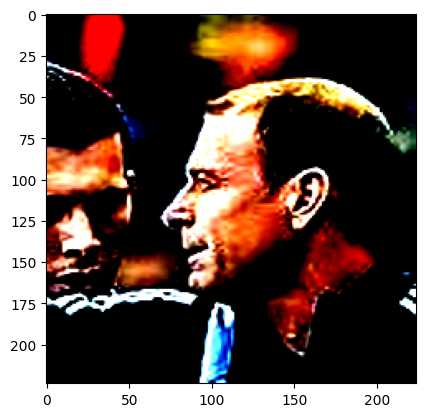

In [201]:
plt.imshow(img[0].permute(1,2,0))

In [202]:
ipd.Audio(aud[0], rate=16000)